In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random as rn
import time
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, timedelta


def estimateGaussian(x):
    m, n = x.shape
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))
    mu = (1/m)*np.nansum(x, axis=0)
    sigma2 = (1/(m-1))*np.nansum((x-mu)**2,axis=0)  
    return mu, sigma2


def add_random ( dataset, sigma2 ):
    dataset = [dataset[i,:] + rn.uniform(0, sigma2**(1/6)) for i,j in enumerate(dataset)]
    return dataset


def add_n_years (dataset, n_year, y_datasets=0):
    new_dataset = dataset
    sigma2 = estimateGaussian(dataset)[1]
    for i in range(n_year-1):
        start_time = time.time()
        new_dataset = np.concatenate((new_dataset, add_random(dataset, sigma2)), axis=0)
        print('Loading', str(i+2), " - year ---------- %s seconds ---" % (time.time() - start_time))   
    return new_dataset, (list(y_datasets)*n_year)


def spread_window(X, y, window_size):
    X_new = X[window_size:,:]
    for i in range(window_size):
        X_new = np.concatenate((X_new, X[window_size-(i+1):-(i+1),:] ), axis = 1)
    y_new = y[window_size:]
    return X_new, y_new


def reading_file(file_name):
    df= pd.read_excel(file_name, columns = ['Date & Time','FI_C771J1.PV','FI_C771J2.PV','HC_C771L.OP','HC_C771J1.OP','TI_C771T11.PV','TI_C771T21.PV','TI_C771T31.PV','TI_C771T41.PV','TI_C771T51.PV','TI_C771T61.PV','VI_C771X11.PV','VI_C771X21.PV','VI_C771W11.PV','VI_C771W21.PV','VI_C771V11.PV','VI_C771V21.PV','VI_C771U11.PV','VI_C771U21.PV','PI_C771C2.PV','PI_C771H.PV','IT_C771F'])
    X = np.array(df.fillna(0))[:,1:-1]
    y = df['y']
    return X, y

In [2]:
# Read and formatting data
X, y = reading_file('Shufling_maintenance.xlsx')

# Add window for data
window = 24
X_new, y_new = spread_window(X, y, window)

In [3]:
# Calulate data with random for extra n years

n = 3 # number of years for addin to data
X_n_years, y_n_years = add_n_years(X_new, n, y_new)

Loading 2  - year ---------- 3.6186439990997314 seconds ---
Loading 3  - year ---------- 3.6635982990264893 seconds ---


In [4]:
# Building model

X_train, X_test, y_train, y_test = train_test_split(X_n_years, y_n_years, test_size = 0.2)
lm = RandomForestClassifier(n_estimators=50)
model = lm.fit ( X_train, y_train )
print('Score: ', model.score( X_test, y_test) *100)

Score:  99.78233474624814


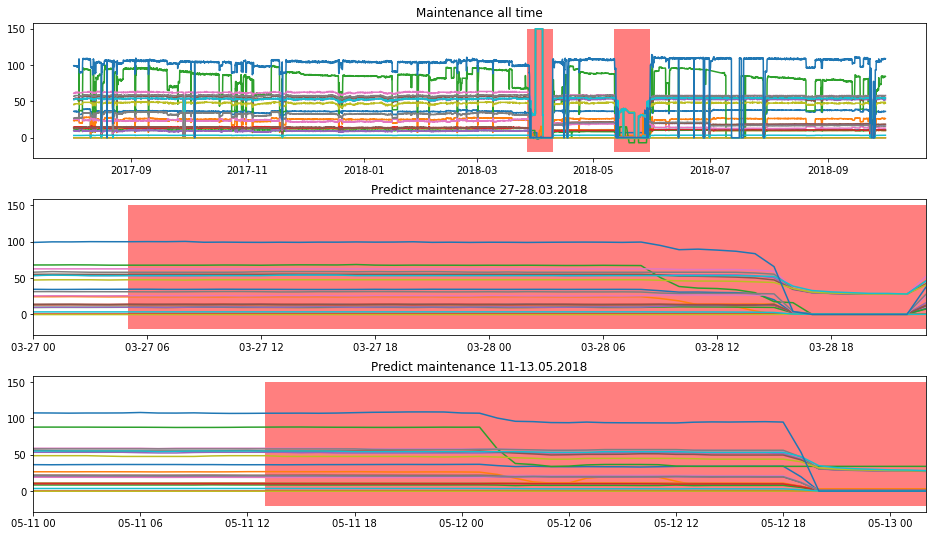

In [5]:
# # Downloading real data for testing
X_original, y_original = reading_file('Data_new_21.xlsx')

x_date_axis = [datetime(2017,8,1,0,0)+ timedelta(hours = i) for i,j in enumerate(X_original)][window:]
pred_y = model.predict(spread_window(X_original, y_original, window)[0])

# Plotting resul
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(16,9))
plt.subplots_adjust(hspace=0.3)

ax1.plot(x_date_axis, X_original[window:,:])
ax1.fill_between(x_date_axis, -20, 150, where= pred_y ==1, facecolor='red', alpha = 0.5)
ax1.set_title('Maintenance all time')

ax2.plot(x_date_axis, X_original[window:,:])
ax2.fill_between(x_date_axis, -20, 150, where= pred_y ==1, facecolor='red', alpha = 0.5)
ax2.set_xlim(datetime(2018,3,27,0,0), datetime(2018,3,28,23,0))
ax2.set_title('Predict maintenance 27-28.03.2018')

ax3.plot(x_date_axis, X_original[window:,:])
ax3.fill_between(x_date_axis, -20, 150, where= pred_y ==1, facecolor='red', alpha = 0.5)
ax3.set_xlim(datetime(2018,5,11,0,0), datetime(2018,5,13,2,0))
ax3.set_title('Predict maintenance 11-13.05.2018')
plt.show()

In [6]:
##Table

In [7]:
y_table = list(reading_file('Time_maintenance.xlsx')[1][window:])*n
predict_table = model.predict(add_n_years(X_new, n, y_new)[0])
x_date = [datetime(2017,8,1,0,0) + timedelta(hours = i) for i,j in enumerate(predict_table)][window:]

Loading 2  - year ---------- 3.716548204421997 seconds ---
Loading 3  - year ---------- 3.6715927124023438 seconds ---


In [8]:
res_predict = [j for i,j in enumerate(x_date) if predict_table[i] == 1 and predict_table[i-3] == 0 and predict_table[i-2] == 0 and predict_table[i-1] == 0 ]
res_real = [ j for i,j in enumerate(x_date) if (y_table[i] == 1 ) ]

for i,j in enumerate(res_predict):
    if  res_real[i] - res_predict[i] > timedelta(days=5):
        res_real.append(datetime(2018,1,1,0,0))
        res_real[i+1:] = res_real[i:-1]
        res_real[i]=0

In [9]:
with open('oufile.txt', 'w') as f:
    f.write("  Differences   --  date of Prediction  -----  date of real alarm \n\n" )
    for i,j in enumerate(res_real):
        diff = ['  extra predict' if (res_real[i]==0) else (res_real[i]-res_predict[i]).seconds/3600 + 24]
        f.write(" %s -- %s -----  %s \n " % (diff[0], res_predict[i], res_real[i]))